In [1]:
from skimage import io
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np 
%matplotlib inline

from keras.models import *
from keras.layers import Input, Conv2D, MaxPooling2D, Conv2DTranspose, Dropout, concatenate, Reshape, Permute, Lambda
from keras.activations import softmax
from keras.optimizers import *
from keras.callbacks import ModelCheckpoint, LearningRateScheduler
from keras import backend as K
from keras.utils import np_utils

/home/marloes/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


### Load image data

In [2]:
im_full_stack = io.imread('20171214_MGAN0011_-ROIa2.tif') # 16 slice stack
#im_labels = io.imread('20171214_MGAN0011_-ROIa2-CD3_labels.tif') # simple 1 slice labels
im_labels2 = io.imread('Labels2.tif') # more advanced labels with 2 slices: labels and weights for 3 classes 
im_test = io.imread('20171214_MGAN0011_-ROIa2-CD3.tif')
im_size = im_labels2[0].shape

im_labels  = im_labels2[0] # labels are 0 - backgrounsd, 1 - intermediate region, 2 - cell
im_weights = im_labels2[1] # weights are 1 for class 11 conflicts, 2 for class 21 or 12 conflicts, 
                            #3 for class 22 conflicts, and 4 for 122 or any other 3-digit (3-object) conflicts

# swap the dimentions for keras, so the channels are in the end
im_full_stack = np.moveaxis(im_full_stack, 0, 2)

### Visualize images

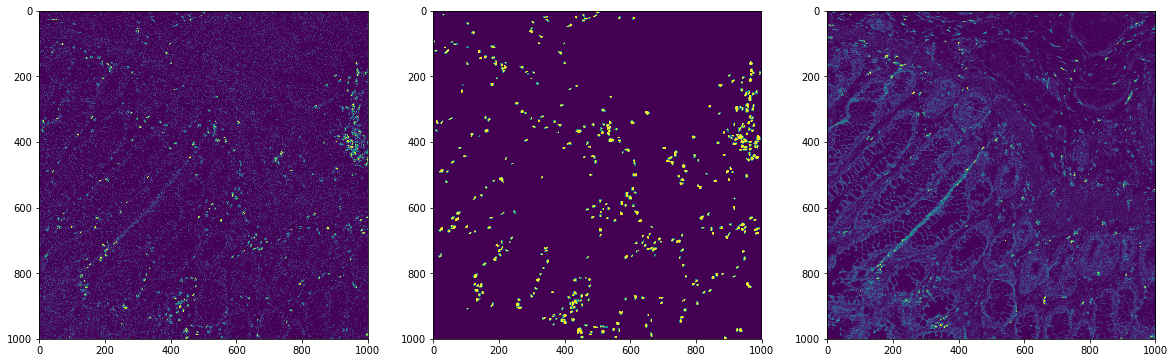

In [3]:
f, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(20, 8))
ax1.imshow(im_test)
ax2.imshow(im_labels)
ax3.imshow(im_full_stack[:,:,9])
print()

### Create patches for training 

In [63]:
# randomly generate N patches of size patch_size and select for training only a 
# subset which contains enough pixels with class 1 and 2
N = 3000
min_class_size = 700
patch_size = 112

corner_i = np.random.randint(low = 0, high = im_size[0] - patch_size, size = N)
corner_j = np.random.randint(low = 0, high = im_size[0] - patch_size, size = N)

train_labels = []
train_data = []

Nreal = 0
for i, j in zip (corner_i, corner_j):
        if im_labels[i:i + patch_size, j:j + patch_size].sum() > min_class_size:
            train_labels.append(im_labels[i:i + patch_size, j:j + patch_size])
            train_data.append(im_full_stack[i:i + patch_size, j:j + patch_size, :] / 65535) # normalize the data, does not work without
            Nreal += 1

train_labels = np.asarray(train_labels)
train_data   = np.asarray(train_data)

# convert labes to categorical values one-hot
n_classes = 3
train_labels = np_utils.to_categorical(train_labels, num_classes = n_classes)
train_labels = train_labels.reshape(Nreal, patch_size, patch_size, n_classes)

print ('Selected', Nreal, 'patches out of', N)

Selected 1061 patches out of 3000


### Data augmentation, rotation and flips

In [6]:
train_data90  = np.rot90(train_data, 1, axes =(1, 2))
train_data180 = np.rot90(train_data, 2, axes =(1, 2))
train_data270 = np.rot90(train_data, 3, axes =(1, 2))

train_labels90  = np.rot90(train_labels, 1, axes =(1, 2))
train_labels180 = np.rot90(train_labels, 2, axes =(1, 2))
train_labels270 = np.rot90(train_labels, 3, axes =(1, 2))

train_flip = np.flip(train_data, 1)
train_flip90  = np.rot90(train_flip, 1, axes =(1, 2))
train_flip180 = np.rot90(train_flip, 2, axes =(1, 2))
train_flip270 = np.rot90(train_flip, 3, axes =(1, 2))

train_labels_flip = np.flip(train_labels, 1)
train_labels_flip90  = np.rot90(train_labels_flip, 1, axes =(1, 2))
train_labels_flip180 = np.rot90(train_labels_flip, 2, axes =(1, 2))
train_labels_flip270 = np.rot90(train_labels_flip, 3, axes =(1, 2))

train_data   = np.concatenate((train_data, train_data90, train_data180, train_data270, train_flip, \
                               train_flip90, train_flip180, train_flip270), axis = 0)
train_labels = np.concatenate((train_labels, train_labels90, train_labels180, train_labels270, \
                               train_labels_flip, train_labels_flip90, train_labels_flip180, \
                               train_labels_flip270), axis = 0)

#f, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(20, 8))
#ax1.imshow(testim[1,:,:,6])
#ax2.imshow(train_data90[1,:,:,6])
#ax3.imshow(train_labels90[1,:,:,2])
train_data.shape

(8784, 112, 112, 16)

### Custom defined loss

In [101]:
def weighted_loss(y_true, y_pred):
    '''
    Custom loss function to be used for line fitting (because a line mask has
    a much smaller number of pixels labelled as line than a region mask has
    pixels labelled as region). Weights are computed on the fly based on the
    ground truth. This means the error on each class is weighted similarly.
    '''
    # Compute weights.
    # Note that this is per batch.
    # In practice this does not really seem to be a good idea..
    # weights = [K.sum(K.sum(K.sum(y_true, 0), 0), 0)
    # weights = 1 / K.clip(weights, 1, None)]
    weights = [1, 10, 10] # 0 index is the background, 1 is a boundary pixels and 2 is a cell
    
    y_pred_c = K.clip(y_pred, K.epsilon(), 1)
    elms = y_true * K.log(y_pred_c) #+ (1 - y_true_c) * K.log(1 - y_pred_c)
    
    total =  K.mean(elms, (0,1,2))
    loss  = -K.sum(weights * total)
    
    # keras version
    #loss = K.categorical_crossentropy(y_true, y_pred)
    
    # tensorflow version
    #loss = tf.nn.sigmoid_cross_entropy_with_logits(labels = y_true, logits = y_pred)
    #loss = tf.reduce_mean(loss)

    return loss

### Unet

In [102]:
inputs = Input((patch_size, patch_size, 16))
conv1 = Conv2D(32, (3, 3), activation='relu', padding='same')(inputs)
conv1 = Conv2D(32, (3, 3), activation='relu', padding='same')(conv1)
pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)
print(conv1.shape)

conv2 = Conv2D(64, (3, 3), activation='relu', padding='same')(pool1)
conv2 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv2)
pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)
print(conv2.shape)

conv3 = Conv2D(128, (3, 3), activation='relu', padding='same')(pool2)
conv3 = Conv2D(128, (3, 3), activation='relu', padding='same')(conv3)
pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)
print(conv3.shape)

conv4 = Conv2D(256, (3, 3), activation='relu', padding='same')(pool3)
conv4 = Conv2D(256, (3, 3), activation='relu', padding='same')(conv4)
pool4 = MaxPooling2D(pool_size=(2, 2))(conv4)
print(conv4.shape)

conv5 = Conv2D(512, (3, 3), activation='relu', padding='same')(pool4)
conv5 = Conv2D(512, (3, 3), activation='relu', padding='same')(conv5)
print(conv5.shape)

up6 = concatenate([Conv2DTranspose(256, (2, 2), strides=(2, 2), padding='same')(conv5), conv4], axis=3)
conv6 = Conv2D(256, (3, 3), activation='relu', padding='same')(up6)
conv6 = Conv2D(256, (3, 3), activation='relu', padding='same')(conv6)

up7 = concatenate([Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(conv6), conv3], axis=3)
conv7 = Conv2D(128, (3, 3), activation='relu', padding='same')(up7)
conv7 = Conv2D(128, (3, 3), activation='relu', padding='same')(conv7)

up8 = concatenate([Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(conv7), conv2], axis=3)
conv8 = Conv2D(64, (3, 3), activation='relu', padding='same')(up8)
conv8 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv8)

up9 = concatenate([Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(conv8), conv1], axis=3)
conv9 = Conv2D(32, (3, 3), activation='relu', padding='same')(up9)
conv10 = Conv2D(32, (3, 3), activation='relu', padding='same')(conv9)

conv11 = Conv2D(n_classes, (1, 1), activation='linear')(conv10)
#print(conv10.shape)

out = Lambda(lambda x: softmax(x, axis = 3))(conv11)

model = Model(inputs=[inputs], outputs=[out])

model.compile(optimizer = 'adam', loss = weighted_loss, metrics=['accuracy'])

(?, 112, 112, 32)
(?, 56, 56, 64)
(?, 28, 28, 128)
(?, 14, 14, 256)
(?, 7, 7, 512)


In [90]:
model_checkpoint = ModelCheckpoint('weights.h5', monitor='val_loss', save_best_only=True)

history = model.fit(train_data, train_labels, batch_size=32, epochs=10, verbose=1, shuffle=True,
              validation_split=0.1,
              callbacks=[model_checkpoint])

Train on 954 samples, validate on 107 samples
Epoch 1/10
954/954 [==============================] - 9s - loss: 0.0655 - acc: 0.9927 - val_loss: 0.1166 - val_acc: 0.9888
Epoch 2/10
954/954 [==============================] - 10s - loss: 0.0524 - acc: 0.9940 - val_loss: 0.1142 - val_acc: 0.9908
Epoch 3/10
954/954 [==============================] - 8s - loss: 0.0559 - acc: 0.9938 - val_loss: 0.1186 - val_acc: 0.9906
Epoch 4/10
954/954 [==============================] - 8s - loss: 0.0458 - acc: 0.9948 - val_loss: 0.1174 - val_acc: 0.9921
Epoch 5/10
954/954 [==============================] - 8s - loss: 0.0382 - acc: 0.9957 - val_loss: 0.1237 - val_acc: 0.9926
Epoch 6/10
954/954 [==============================] - 8s - loss: 0.0383 - acc: 0.9956 - val_loss: 0.1201 - val_acc: 0.9928
Epoch 7/10
954/954 [==============================] - 8s - loss: 0.0371 - acc: 0.9957 - val_loss: 0.1195 - val_acc: 0.9930
Epoch 8/10
954/954 [==============================] - 8s - loss: 0.0378 - acc: 0.9957 - val_

dict_keys(['val_loss', 'val_acc', 'loss', 'acc'])


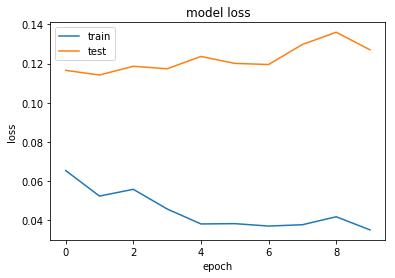

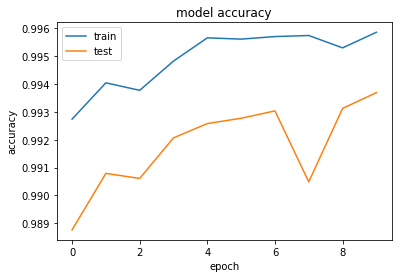

In [95]:
print(history.history.keys())
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

# summarize history for accuracy
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()


### User defined (interesting) patches

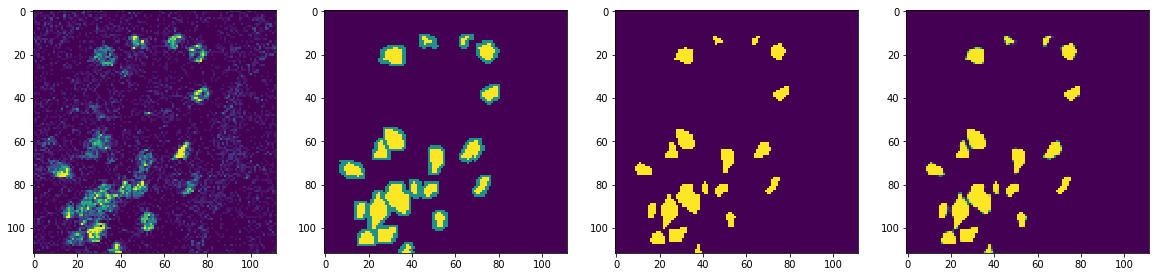

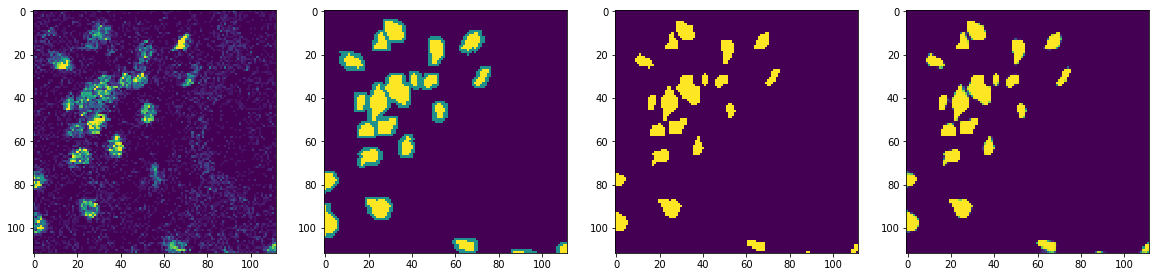

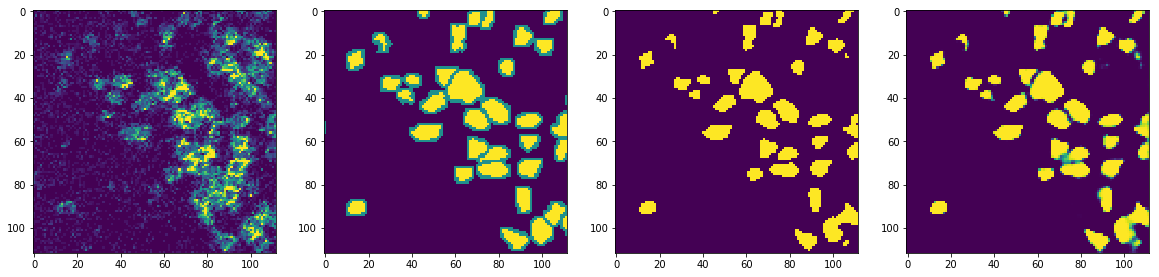

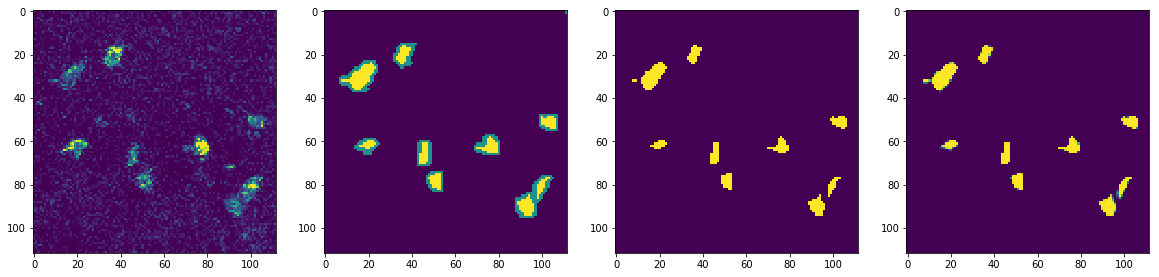

In [96]:
model.load_weights('weights.h5')

main_slice = 6
im1 = im_full_stack[800:800 + patch_size, 400:400 + patch_size, :] /65535
label1 = im_labels[800:800 + patch_size, 400:400 + patch_size] 
im_predict = model.predict(im1.reshape(1, patch_size, patch_size, 16))
f, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, figsize=(20, 8))
ax1.imshow(im1[:,:,main_slice])
ax2.imshow(label1[:,:])
ax4.imshow(im_predict[0,:,:,2])

binarymask = im_predict[0,:,:,2]
binarymask[binarymask >=0.8] = 1
binarymask[binarymask <0.8] = 0
ax3.imshow(binarymask)


im1 = im_full_stack[850:850 + patch_size, 400:400 + patch_size, :] /65535
label1 = im_labels[850:850 + patch_size, 400:400 + patch_size] 
im_predict = model.predict(im1.reshape(1, patch_size, patch_size, 16))
f, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, figsize=(20, 8))
ax1.imshow(im1[:,:,main_slice])
ax2.imshow(label1[:,:])
ax4.imshow(im_predict[0,:,:,2])

binarymask = im_predict[0,:,:,2]
binarymask[binarymask >=0.8] = 1
binarymask[binarymask <0.8] = 0
ax3.imshow(binarymask)


im1 = im_full_stack[350:350 + patch_size, 870:870 + patch_size, :] /65535
label1 = im_labels[350:350 + patch_size, 870:870 + patch_size] 
im_predict = model.predict(im1.reshape(1, patch_size, patch_size, 16))
f, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, figsize=(20, 8))
ax1.imshow(im1[:,:,main_slice])
ax2.imshow(label1[:,:])
ax4.imshow(im_predict[0,:,:,2])

binarymask = im_predict[0,:,:,2]
binarymask[binarymask >=0.8] = 1
binarymask[binarymask <0.8] = 0
ax3.imshow(binarymask)




im1 = im_full_stack[600:600 + patch_size, 800:800 + patch_size, :] /65535
label1 = im_labels[600:600 + patch_size, 800:800 + patch_size] 
im_predict = model.predict(im1.reshape(1, patch_size, patch_size, 16))
f, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, figsize=(20, 8))
ax1.imshow(im1[:,:,main_slice])
ax2.imshow(label1[:,:])
ax4.imshow(im_predict[0,:,:,2])

binarymask = im_predict[0,:,:,2]
binarymask[binarymask >=0.8] = 1
binarymask[binarymask <0.8] = 0
ax3.imshow(binarymask)

### Random patches from the training set

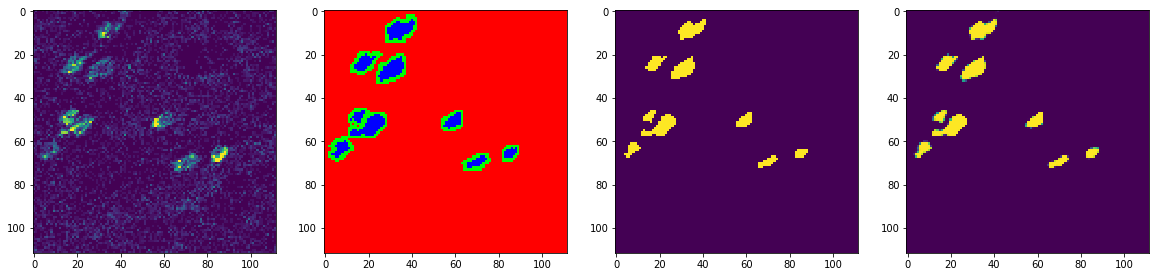

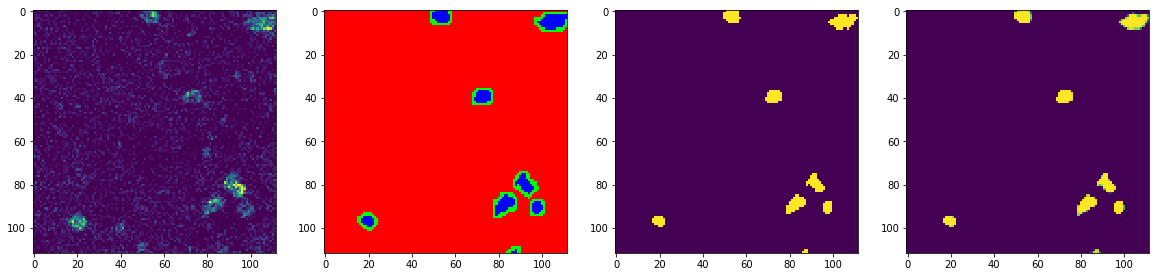

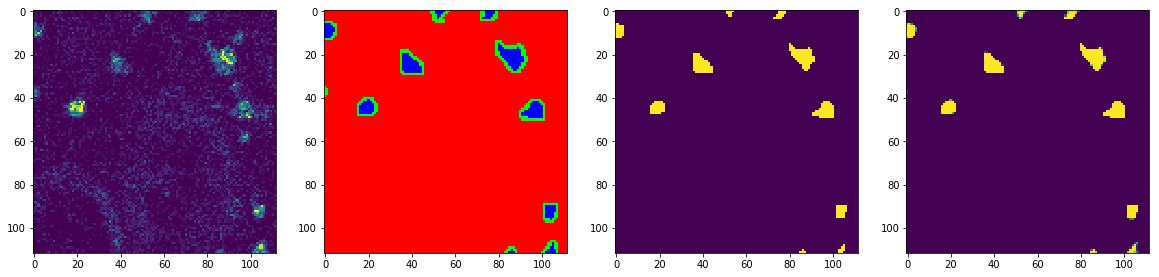

In [114]:
model.load_weights('weights.h5')

main_slice = 6

im_predict = model.predict(train_data[1:2,:,:, :])
f, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, figsize=(20, 8))
ax1.imshow(train_data[1,:,:,main_slice])
ax2.imshow(train_labels[1,:,:])
ax4.imshow(im_predict[0,:,:,2])

binarymask = im_predict[0,:,:,2]
binarymask[binarymask >=0.8] = 1
binarymask[binarymask <0.8] = 0
ax3.imshow(binarymask)



im_predict = model.predict(train_data[5:6,:,:,:])
f, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, figsize=(20, 8))
ax1.imshow(train_data[5,:,:,main_slice])
ax2.imshow(train_labels[5,:,:])
ax4.imshow(im_predict[0,:,:,2])

binarymask = im_predict[0,:,:,2]
binarymask[binarymask >=0.8] = 1
binarymask[binarymask <0.8] = 0
ax3.imshow(binarymask)

im_predict = model.predict(train_data[8:9,:,:,:])
f, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, figsize=(20, 8))
ax1.imshow(train_data[8,:,:,main_slice])
ax2.imshow(train_labels[8,:,:])
ax4.imshow(im_predict[0,:,:,2])

binarymask = im_predict[0,:,:,2]
binarymask[binarymask >=0.8] = 1
binarymask[binarymask <0.8] = 0
ax3.imshow(binarymask)


In [35]:
train_labels.shape

(690, 112, 112, 3)